## Práctica 1 - Detección de paneles de señalización vertical azul en autovías

Se desea construir un sistema para la detección automática de paneles informativos de tráfico de color azul, en imágenes realistas que han sido tomadas desde un coche (ver figura adjunta). Los paneles se han diseñado para que sean fácilmente distinguibles del entorno en cualquier condición de luz, color de fondo y climatología.

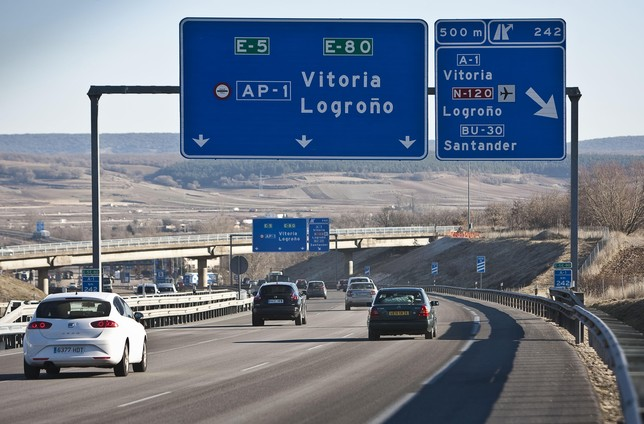

Observando la imagen adjunta podemos hacernos una idea sobre el tipo de información que nos permitirá distinguir un tipo de otro de panel, e incluso localizarlos en una imagen de carretera. En particular, se distinguen por su forma geométrica rectangular, por las zonas en las que se divide (borde claro y fondo oscuro) o por el color del mismo (azul y blanco). Es decir, para detectar este tipo de paneles podríamos utilizar:
- Un detector de regiones de alto contraste (detectaríamos la parte interna del panel).
- Un algoritmo que detectase rectángulos (p.ej., combinando detección de líneas con detectores de esquinas).
- Un algoritmo para descubrir qué píxeles son de color azul en la imagen junto con su distribución espacial.
- Detectar ciertas formas que aparecen en los paneles en localizaciones especiales (símbolo de salida de la autopista por la izquierda o derecha, diversos tipos de flechas, etc.).
- Cualquier otra técnica que tenga en cuenta color y forma.

El objetivo de esta práctica es desarrollar un detector básico de sub-paneles de información en autovías (como se ve en la figura adjunta). Hablamos de sub-paneles porque la idea es detectar cada una de las regiones rectangulares azules enmarcadas con un borde blanco en los paneles de la carretera. Para desarrollar el algoritmo de detección, como en muchos otros problemas de este tipo, se ofrece una
colección de imágenes de test tomadas desde un coche.

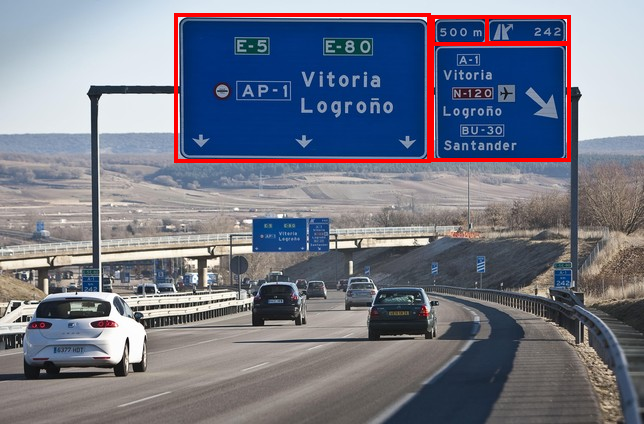

In [17]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import math

## Normalización de las imágenes de los paneles detectados

Muchos paneles detectados en las imágenes pueden aparecer ligeramente rotados (debido al efecto de la perspectiva) y/o también afectados por unas condiciones de iluminación desfavorable. Ello puede  dificultar el posterior reconocimiento de la información contenida en los mismos. La Figura adjunta ilustra un ejemplo de esta situación.

![image-2.png](attachment:image-2.png)

En este apartado se pide desarrollar una función que aplique las normalizaciones que se consideren con respecto a la posición del cartel en la imagen y/o la corrección del efecto de la iluminación.

Mostrar gráficamente el resultado de aplicar dicha normalización sobre un conjunto de imágenes que lo requieran.

In [18]:
def detect_lines(image):
    # Parametros
    rho = 1
    theta = np.pi / 180
    threshold = 45
    min_line_length = 80
    max_line_gap = 10
    
    max_horizontal_threshold = 10  
    ang = 0 
    
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)  

    angles = []
    try:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if abs(y2 - y1) < max_horizontal_threshold:
                    m = (y2 - y1) / (x2 - x1)
                    angles.append(math.atan(m))                
       
    except Exception as e:
        print()
    angles.sort()
    if (len(angles)>0):
        ang = angles[len(angles)//2]
    ang = ang * (180 / math.pi)
    return ang


In [19]:
def detect_horizontal_edges(image, threshold=50):
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)    # Convertir los valores negativos a positivos
    sobel_y = np.abs(sobel_y)
    sobel_y = np.uint8(255 * sobel_y / np.max(sobel_y))
    edges_horizontal = cv2.threshold(sobel_y, threshold, 255, cv2.THRESH_BINARY)[1]

    return edges_horizontal

In [20]:
lower_blue_limit2 = np.array([60,70,90])
upper_blue_limit2 = np.array([120, 255, 190])

def apply_blue_filter2(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img, lower_blue_limit2, upper_blue_limit2)
    return mask

In [21]:
def straighten_image(imagen, angulo):
    altura, ancho = imagen.shape[:2]
    centro = (ancho // 2, altura // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    imagen_enderezada = cv2.warpAffine(imagen, matriz_rotacion, (ancho, altura))
    return imagen_enderezada

In [22]:
def normalizar(imgs):
    norm_imgs = []
    for image in imgs:
            
            filtered_imageb = apply_blue_filter2(image)
            filtered_imagee = detect_horizontal_edges(filtered_imageb)
            ang = detect_lines(filtered_imagee)

            img = straighten_image(image,ang)

            norm_imgs.append(img)
            
    return norm_imgs

# Carga de imagenes
Cargar las imágenes de aprendizaje en color, guardarlas en una lista y mostrar la primera y la última usando imshow de matplotlib.

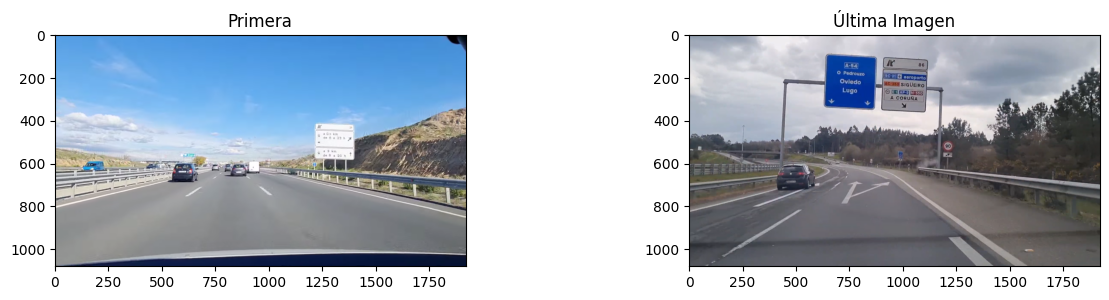

In [23]:
def upload_images(images_dir):
    images = []

    for file in os.listdir(images_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            img_path = os.path.join(images_dir, file)
            image = cv2.imread(img_path)
            if image is not None:
                images.append(image)

    return images

def show_first_and_last(images):
    if len(images) > 0:
        _, axes = plt.subplots(1, 2, figsize=(15, 3))

        axes[0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        axes[0].set_title('Primera')

        axes[1].imshow(cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB))
        axes[1].set_title('Última Imagen')
        plt.show()

    else:
        print("No se encontraron imágenes en la carpeta especificada.")

#------------------------------------------------------------------------------------------------------------- 
original_images = upload_images('imagenesTest')
show_first_and_last(original_images)

# FUNCIONES PARA NORMALIZAR LAS IMAGENES ANTES DE APLICAR MSER

## Filtro de color azul

In [24]:
def blue_filter(images):
    filtered_images = []

    for image in images:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab)
        lab_planes = list(lab_planes)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(img, np.array([90, 155, 0]), np.array([130, 255, 255]))

        filtered_images.append(mask)
    return filtered_images

In [25]:
def blue_filter_img(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    lab_planes = list(lab_planes) 
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img, np.array([90, 155, 0]), np.array([130, 255, 255]))
    return mask

## Incremento de saturación

In [26]:
def increase_saturation(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:,:,1] = np.clip(hsv[:,:,1] * 2.9, 0, 255)
    result = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return result

## Incremento de saturación por imagenes 
Incrementamos la saturación en aquellas imágenes que tienen una media de saturación inferior a 27

In [27]:
def saturacion(images):
    imagesResult = []

    for image in images:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
        s_channel = hsv_image[:,:,1] 
        indexSaturation = np.mean(s_channel) 
        newImage = image.copy()

        if (indexSaturation<27):
            newImage = increase_saturation(newImage) 
            imagesResult.append(newImage) 
        else:
            imagesResult.append(newImage) 

    return imagesResult

saturated_images = saturacion(original_images.copy())
norm_images = normalizar(saturated_images)


# Detección de regiones de alto contraste

Utilizar MSER como detector de regiones de alto contraste (mser.detectRegions). 

Crear una función que aplique MSER a la lista de imágenes. Hay que tener en cuenta que los parámetros de MSER se pueden ajustar en el constructor de la clase (cv2.MSER_create). El ajustar los parámetros puede suponer eliminar muchas detecciones incorrectas (http://stackoverflow.com/questionshttps://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python/17647500/exact-meaning-of-the-parameters-given-to-initialize-mser-in-opencv-2-4-x).

Mostrar el resultado de aplicar la función sobre la primera y la última imagen de la lista usando imshow de matplotlib.

#### Aplicamos el filtro de azul a las imagenes para crear las mascaras donde aplicaremos MSER

In [28]:
filtered_images = blue_filter(norm_images.copy())

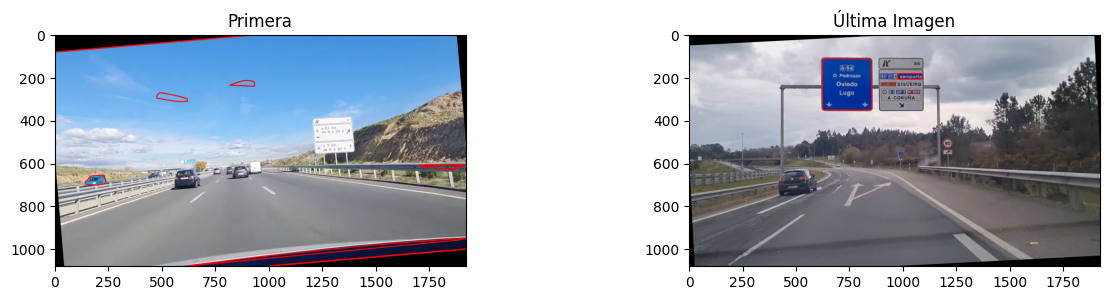

In [29]:
def mser(processed_images, filtered_images):
    images_with_drawn_regions = []
    detected_regions = []

    for i, _ in enumerate(filtered_images):  
        copy_filtered_img = filtered_images[i].copy() # mask
        copy_original = processed_images[i].copy() # To draw the regions

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
        filtered_image = cv2.dilate(copy_filtered_img, kernel)
        filtered_image = filtered_image-copy_filtered_img

        mser = cv2.MSER_create(delta=10, max_variation=0.05, min_area=900, max_area=5000)
        polygons, _ = mser.detectRegions(filtered_image) 

        hulls = []
        for p in polygons:
            hull = cv2.convexHull(p.reshape(-1, 1, 2))
            hulls.append(hull)

        detected_regions.append(polygons)

        cv2.polylines(copy_original, hulls, 1, (0, 0, 255), 3)
        images_with_drawn_regions.append(copy_original)

    show_first_and_last(images_with_drawn_regions)

    return images_with_drawn_regions, detected_regions

#---------------------------------------------------------------------------------------------
images_with_drawn_regions, detected_regions = mser(norm_images.copy(), filtered_images.copy())

In [30]:
# To display the result of all images  
'''
for i,image in enumerate(images_with_drawn_regions):
    cv2.imshow('IMAGE: '+ str(i+1), images_with_drawn_regions[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
'''

"\nfor i,image in enumerate(images_with_drawn_regions):\n    cv2.imshow('IMAGE: '+ str(i+1), images_with_drawn_regions[i])\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n"

Crear una función que extraiga en un rectángulo los píxeles de la región detectada (cv2.boundingRect).

Mostrar gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en el paso anterior.

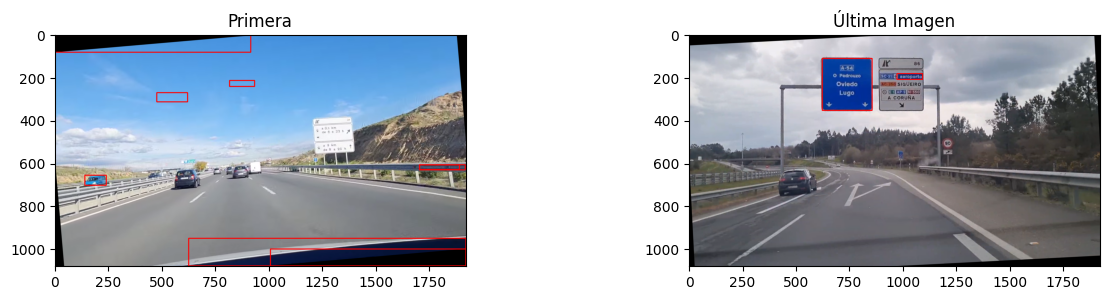

In [31]:
def rectangle_of_regions(processed_images, detected_regions):
    images_with_boxed_regions  = []

    for i, _ in enumerate(processed_images):
        copy = processed_images[i].copy()

        for region in detected_regions[i]:
            x, y, w, h = cv2.boundingRect(region)
            cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 3)

        images_with_boxed_regions.append(copy)
    show_first_and_last(images_with_boxed_regions)

    return images_with_boxed_regions

#---------------------------------------------------------------------------------------------
images_with_boxed_regions = rectangle_of_regions(norm_images.copy(), detected_regions.copy())

In [62]:
# To display the result of all images 
'''
for i,image in enumerate(images_with_boxed_regions):
    cv2.imshow('IMAGEN: '+ str(i+1), images_with_boxed_regions[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
'''

"\nfor i,image in enumerate(images_with_boxed_regions):\n    cv2.imshow('IMAGEN: '+ str(i+1), images_with_boxed_regions[i])\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n"

Crear una función que elimine las regiones con una relación de aspecto (ancho/alto) muy diferente de la que tienen los sub-paneles. Si las regiones son demasiado alargadas en horizontal o vertical se podrán eliminar.

Mostrar gráficamente el resultado de aplicar la función sobre alguna imagen que rechace y sobre otra que acepte.

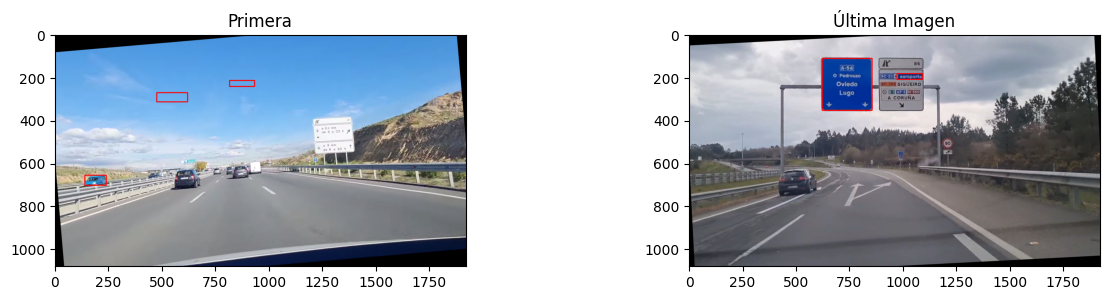

In [71]:
def rectangle_filtered(processed_images, detected_regions):
    images_filtered_rectangles = []
    filtered_regions = []

    for i, _ in enumerate(processed_images):
        filtered_regions_act_img = []
        copy = processed_images[i].copy()  

        for j, region in enumerate(detected_regions[i]):
            x, y, w, h = cv2.boundingRect(region)
            aspect_ratio = w / float(h)

            if aspect_ratio > 0.6 and aspect_ratio < 6.5:
                # We check if the region is inside another region 
                is_inside = False
                for k, other_region in enumerate(detected_regions[i]):
                    if j != k:
                        x_other, y_other, w_other, h_other = cv2.boundingRect(other_region)
                        if x_other <= x and y_other <= y and x_other + w_other >= x + w and y_other + h_other >= y + h:
                            is_inside = True
                            break

                if not is_inside:
                    filtered_regions_act_img.append(region)
                    cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 3)

        filtered_regions.append(filtered_regions_act_img)
        images_filtered_rectangles.append(copy)

    show_first_and_last(images_filtered_rectangles)

    return images_filtered_rectangles, filtered_regions

#---------------------------------------------------------------------------------------------------------------------------------------------
images_filtered_rectangles, filtered_regions = rectangle_filtered(norm_images.copy(), detected_regions.copy())

Nota: Además de filtrar por la relación de aspecto de las regiones detectadas esta función también elimina los rectangulos de las regiones que estén dentro de otros rectangulos

In [64]:
# To display the result of all images 
'''
for i,image in enumerate(images_filtered_rectangles):
    cv2.imshow('IMAGEN: '+ str(i+1), images_filtered_rectangles[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''

"\nfor i,image in enumerate(images_filtered_rectangles):\n    cv2.imshow('IMAGEN: '+ str(i+1), images_filtered_rectangles[i])\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n    "

En los sub-paneles, es posible que MSER haya detectado originalmente la región azul interna al borde blanco. Por tanto, es conveniente agrandar un poco el rectángulo detectado para que la imagen recortada contenga el sub-panel completo (incluyendo el borde blanco, y no sólo su parte interna). Si no se hace esto podemos tener una tasa de detección peor de la que realmente tenemos dado que las detecciones no solaparán completamente con las anotaciones.

Crear una función que agrande la zona y que muestre gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en la celda de la función en MSER.

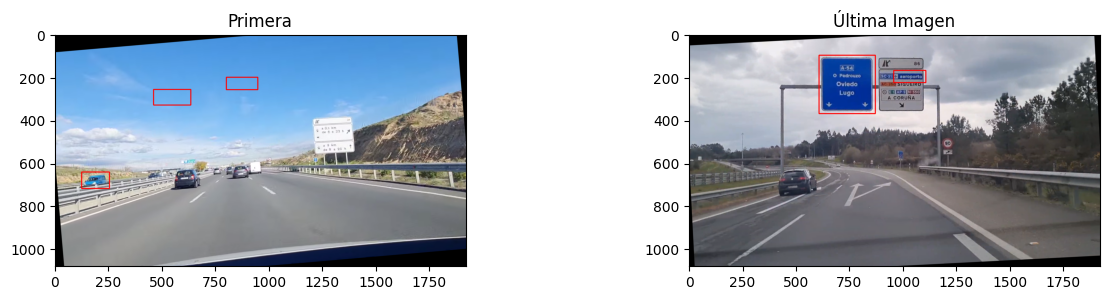

In [76]:
def expand_regions(processed_images, filtered_regions):
    images_extended_regions = []
    extended_regions_coords = []
    possible_panels = []

    for i, img in enumerate(processed_images):
        copy = img.copy()
        extended_regions_img = []
        possible_panels_img = []

        for region in filtered_regions[i]:
            x, y, w, h = cv2.boundingRect(region)

            # we expand the region without leaving the image limits
            x_new = max(0, x - 15)  
            y_new = max(0, y - 15)  
            w_new = min(img.shape[1] - x_new, w + 30)  
            h_new = min(img.shape[0] - y_new, h + 30)  
            tuple_of_coords = (x_new, y_new, w_new, h_new)

            cv2.rectangle(copy, (x_new, y_new), (x_new + w_new, y_new + h_new), (0, 0, 255), 3)
            pixels_region = processed_images[i][y_new:y_new+h_new, x_new:x_new+w_new]

            possible_panels_img.append(pixels_region)
            extended_regions_img.append(tuple_of_coords)

        possible_panels.append(possible_panels_img)
        images_extended_regions.append(copy)
        extended_regions_coords.append(extended_regions_img)

    show_first_and_last(images_extended_regions)

    return images_extended_regions, extended_regions_coords, possible_panels

#--------------------------------------------------------------------------------------------------------------------------
images_extended_regions, extended_regions_coords, possible_panels = expand_regions(norm_images.copy(), filtered_regions)

In [66]:
# To display the result of all images
'''
for i,image in enumerate(images_extended_regions):
    cv2.imshow('IMAGEN: '+ str(i+1), images_extended_regions[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
'''

"\nfor i,image in enumerate(images_extended_regions):\n    cv2.imshow('IMAGEN: '+ str(i+1), images_extended_regions[i])\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n"

#### Deteccion de subpaneles dentro de la region del cartel 
La función mser que hemos desarrollado previamente obtiene la region donde se encuentra el panel. En algunas imagenes es capaz de encontrar dos regiones, la de los subpaneles superiores y la del subpanel inferior. A continuación la idea es teniendo esas regiones encontrar la división de los subpaneles.  

In [77]:
def detect_subpanels(processed_images, possible_panels):
    possible_subpanels = []
    subpanel_coords = []

    for i, _ in enumerate(processed_images):
        possible_subpanels_img = []
        subpanel_coords_img = []

        for pixels_region in possible_panels[i]:
            subpanels_region = []
            high, width = pixels_region.shape[:2]

            enlarged_region = cv2.resize(pixels_region, (int(width * 3), int(high * 3)))
            copy = enlarged_region.copy()

            binary = blue_filter_img(enlarged_region)
            filtered_image = cv2.Canny(binary, 100, 200)

            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
            dilated_image = cv2.dilate(filtered_image, kernel)

            mser = cv2.MSER_create(delta=10, max_variation=0.05, min_area=8000, max_area=50000)
            polygons, _ = mser.detectRegions(dilated_image)

            for polygon in polygons:
                x, y, w, h = cv2.boundingRect(polygon)
                aspect_ratio = w / float(h)
                if aspect_ratio > 0.6 and aspect_ratio < 7:

                    x_new = max(0, x - 20)  
                    y_new = max(0, y - 20)  
                    w_new = min(copy.shape[1] - x_new, w + 40)  
                    h_new = min(copy.shape[0] - y_new, h + 40)  

                    tuple_of_coords_subpanel = (x_new, y_new, w_new, h_new)
                    subpanels_region.append(tuple_of_coords_subpanel)

                    pixels_region_sub = copy[y_new:y_new+h_new, x_new:x_new+w_new]
                    possible_subpanels_img.append(pixels_region_sub)
            subpanel_coords_img.append(subpanels_region)

        subpanel_coords.append(subpanel_coords_img)
        possible_subpanels.append(possible_subpanels_img)

    return possible_subpanels, subpanel_coords

#----------------------------------------------------------------------------------------------------------------------------------------------------------
possible_subpanels, subpanel_coords = detect_subpanels(norm_images.copy(), possible_panels)

In [68]:
# To display all the image of possible subpanels
'''
for i in range(len(possible_subpaneles)):
    for j in range(len(possible_subpaneles[i])):
        cv2.imshow('IMAGEN: '+ str(i) + ' REGION ' + str(j), possible_subpaneles[i][j])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
'''

"\nfor i in range(len(possible_subpaneles)):\n    for j in range(len(possible_subpaneles[i])):\n        cv2.imshow('IMAGEN: '+ str(i) + ' REGION ' + str(j), possible_subpaneles[i][j])\n        cv2.waitKey(0)\n        cv2.destroyAllWindows()\n"

## Función para obtener las coordenadas de los subpaneles en la imagen original 

In [69]:
def fix_choords(images, extended_regions, subpanel_coords):
    subpanels_choords = []
    for i, _ in enumerate(images): 
        subpanels_choords_img = []
        for j, region in enumerate(extended_regions[i]):
            x_r, y_r, _, _ = region
            if(len(subpanel_coords[i][j]) != 0): 
                for subpanel in subpanel_coords[i][j]:
                    x_sp, y_sp, w_sp, h_sp = subpanel

                    x = x_r + x_sp//3
                    y = y_r + y_sp//3 
                    w = w_sp//3
                    h = h_sp//3

                    tuple_choords = (x, y, w, h) 
                    subpanels_choords_img.append(tuple_choords)
        
        subpanels_choords.append(subpanels_choords_img)
    return subpanels_choords

#-----------------------------------------------------------------------------------------------------
subpanels_coordinates = fix_choords(original_images.copy(), extended_regions_coords.copy(), subpanel_coords.copy())

## Detección mediante correlación de máscaras

En esta sección se desea utilizar el espacio de color HSV para localizar los píxeles que sean del color azul (característico del panel) y que estén muy saturados (tiene que ser un azul bastante puro). 

Para ello, en primer lugar se necesita construir una máscara ideal. Por ejemplo un np.array de tamaño fijo (p.ej. 40x80) en el que los píxeles azules y muy saturados tengan valor 1, y 0 el resto. Esta matriz será la máscara de color azul saturado del sub-panel informativo general. La máscara indicaría en qué píxeles debería tener color azul saturado el subpanel.

Mostrar gráficamente la máscara ideal usando imshow.

En el lado izquierdo veremos la imagen original del cartel ideal y en el lado derecho el cartel ideal tras haber aplicado el filtro de azul 

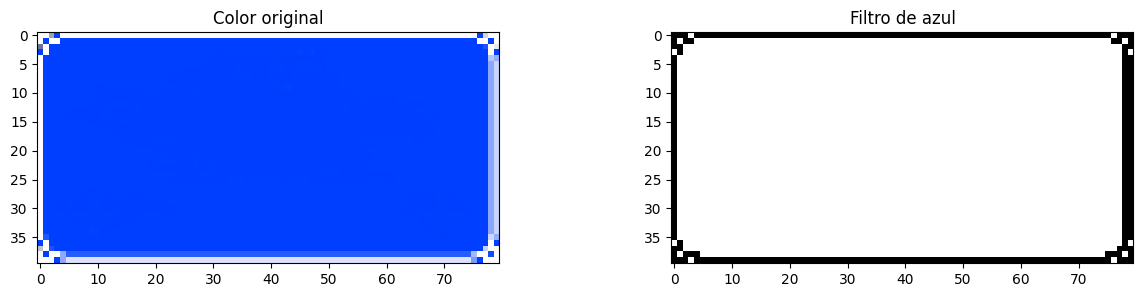

In [70]:
ideal_mask = cv2.imread("./ideal_mask.png", 1)
ideal_mask = cv2.resize(ideal_mask, (80, 40))

ideal_mask_blue = blue_filter_img(ideal_mask.copy())

_, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].imshow(cv2.cvtColor(ideal_mask, cv2.COLOR_BGR2RGB))
axes[0].set_title('Color original')

axes[1].imshow(cv2.cvtColor(ideal_mask_blue, cv2.COLOR_BGR2RGB))
axes[1].set_title('Filtro de azul')

plt.show()


Crear una función que recorte cada ventana detectada por MSER en una imagen y devuelva una lista de imágenes con un tamaño fijo (p.ej. 40x80 píxeles) usando cv2.resize.


Mostrar gráficamente el resultado de aplicar dicha función sobre una imagen que tenga varios paneles.

In [71]:
NUM_IMG = 5

In [72]:
# To show the result in image img
def show_panels(num_img, panels):
    if(len(panels[num_img]) > 1):
        _, axes = plt.subplots(1, len(panels[num_img]), figsize=(15, 3))

        for i, supanel in enumerate(panels[num_img]): 
            axes[i].imshow(cv2.cvtColor(supanel, cv2.COLOR_BGR2RGB))
            axes[i].set_title('Region: ' + str(i+1))

        plt.show()
    else: 
        plt.imshow(cv2.cvtColor(supanel, cv2.COLOR_BGR2RGB))
        plt.show()

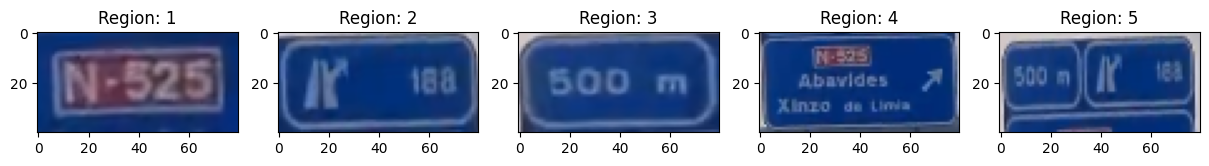

In [73]:
def resize(possible_subpanels): 
    possible_subpanels_redim = []

    for i in range(len(possible_subpanels)):
        possible_subpanels_i_redim = []

        for possible_subpanel in possible_subpanels[i]:
            possible_subpanel_redim = cv2.resize(possible_subpanel, (80, 40))
            possible_subpanels_i_redim.append(possible_subpanel_redim)

        possible_subpanels_redim.append(possible_subpanels_i_redim)

    return possible_subpanels_redim

#------------------------------------------------------------------------------------------------------------
subpanels_redim = resize(possible_subpanels)
show_panels(NUM_IMG ,subpanels_redim)

Crear una función que extraiga los píxeles de color azul saturado (que llamaremos M) de la ventana redimensionada.

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior.

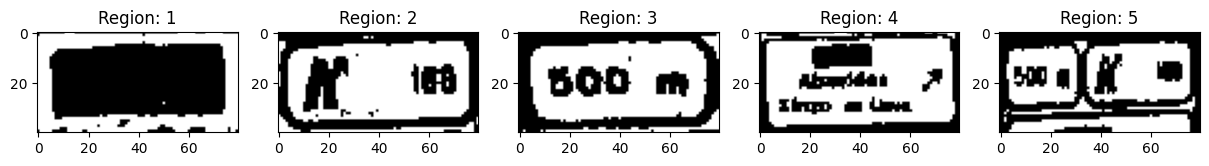

In [74]:
def extract_blue(subpanels_redim): 
    panel_masks = []
    for image_panels in subpanels_redim:
        subpanels_masks = []
        
        for panel in image_panels: 
            subpanel_blue_filter = blue_filter_img(panel)
            subpanels_masks.append(subpanel_blue_filter)
            
        panel_masks.append(subpanels_masks)

    return panel_masks

#----------------------------------------------------------------------------------------------------------
subpanels_masks = extract_blue(subpanels_redim)
show_panels(NUM_IMG ,subpanels_masks)

Crear una función que correle M (multiplicar elemento a elemento y sumar), con la máscara de color azul saturado ideal que debería tener un sub-panel de carretera (p.ej. casi todos los píxeles a 1). Se puede
usar el valor de correlación para saber cuál es la proporción de píxeles de color azul saturado en el sub-panel evaluado. 

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior y que muestre también el valor numérico de dicha correlación.

Si se pone un umbral también se pueden rechazar ventanas como “no panel” cuando tienen una correlación muy baja (es decir, las que “tienen poco azul”).

Si al correlar se supera el umbral, establecer el valor de correlación como la puntuación, o score, que daremos a esa ventana detectada. Ello nos indicará “cómo de parecido es lo detectado a un sub-panel” esa parte de la imagen (0 no es sub-panel y 1 sí lo es).

Establecer un umbral que permita rechazar algunas imágenes que realmente habría que rechazar y que acepte algunas imágenes que debería aceptar.

Mostrar gráficamente algunas imágenes, los valores de correlación obtenidos y el resultado de aplicar el umbral.

In [75]:
IDEAL_BLUE_NUMBER = np.sum(ideal_mask_blue)/255

In [76]:
def correlation(masks, coords):
    scoreds_masks = []
    for mask, coord in zip(masks, coords):

        correlation_image = mask/255 * ideal_mask_blue/255
        
        correlation = ((np.sum(correlation_image)) / IDEAL_BLUE_NUMBER)
        if(correlation > 1.):
            correlation = 0.
        if correlation > 0.4:
            scored_mask = (coord, correlation)
            scoreds_masks.append(scored_mask)
    return scoreds_masks

In [77]:
def all_correlation(masks_list, coords_list):
    scoreds_and_coords_list = []
    for masks, coords in zip(masks_list, coords_list):
        scoreds_coords = correlation(masks, coords)
        scoreds_and_coords_list.append(scoreds_coords)
    return scoreds_and_coords_list
#--------------------------------------------------------------
score_list = all_correlation(subpanels_masks, subpanels_coordinates) 

## Eliminación de detecciones repetidas

MSER detecta la parte interna del sub-panel (p.ej. la parte azul dentro del borde blanco) varias veces dependiendo de los parámetros que le pasemos y además la parte externa (el borde), con lo que muy probablemente tendremos más de una detección correspondiente a cada sub-panel. En esta parte de la práctica se pide diseñar un algoritmo para la que las ventanas repetidas se queden reducidas a una sola detección. Este algoritmo puede utilizar alguna de las siguientes ideas:
- Definir un criterio de solapamiento de ventanas (p.ej. el área de la intersección dividido por el área de la unión de dos ventanas).
- Elegir la ventana que contenga a otras de las que se solapen.
- Elegir la ventana promedio de las que solapen.
- Otros criterios propuestos por los alumnos.

Crear una función filtre los resultados de MSER y mostrar los resultados de aplicar dicha función sobre algunos ejemplos donde tenga impacto.

In [78]:
# Estas funciones las vamos a usar para el posterior método NMS:

# Función que reordena dos listas de forma descendente
def reorderScores(scores, boxes):
    boxesAux = []
    scoresAux = []
    for i in range (len(scores)):
        score = scores[i]
        box = boxes[i]
        if(len(scoresAux) == 0):
            scoresAux.append(score)
            boxesAux.append(box)
        else:
            for j in range(len(scoresAux)):
                if (score >= scoresAux[j]):
                    scoresAux.insert(j, score)
                    boxesAux.insert(j, box)
                    break
                elif (j == len(scoresAux)-1 and score < scoresAux[j]):
                    scoresAux.append(score)
                    boxesAux.append(box)
                    break
    return scoresAux, boxesAux

# Obtiene el valor IoU sobre dos regiones
def intersectionOverUnion(box1, box2):
    # Obtenemos los puntos x1,y1 y x2, y2 de la región primera
    x, y, w, h = box1
    xA1 = x
    yA1 = y
    x = x + w
    y = y + h
    xA2 = x
    yA2 = y
    # Obtenemos los puntos x1,y1 y x2, y2 de la región segunda
    x, y, w, h = box2
    xB1 = x
    yB1 = y
    x = x + w
    y = y + h
    xB2 = x
    yB2 = y
    x1 = max(xA1, xB1)
    y1 = max(yA1, yB1)
    x2 = min(xA2, xB2)
    y2 = min(yA2, yB2)
    intersectionArea = (x2 - x1) * (y2 - y1)
    if (intersectionArea < 0):
        intersectionArea = 0
    box1Area = abs((xA2 - xA1) * (yA1 - yA2))
    box2Area = abs((xB2 - xB1) * (yB1 - yB2))
    return intersectionArea / (box1Area + box2Area - intersectionArea + 1e-6)

In [79]:
def eliminateRepeatedRegions(scores_and_coords):
    # Lista con las coordenadas de los cuadrados finales
    filtered_coords = []
    count = 0

    # Recoremos la lista que contiene las puntuaciones y coordendas de cada imagen
    for score_and_coords in scores_and_coords:
        scores = []
        boxes = []
        # Recoremos la lista de una imagen y añadimos sus puntuaciones y las coordenadas de las boxes
        for elem in score_and_coords:
            boxes.append(elem[0])
            scores.append(elem[1])
        # Calculamos el NMS para la imagen seleccionada
        filtered_boxes = nms_detector(boxes, scores, 0.05)
        # Pintamos las regiones filtradas sobre la imagen dada
        count = count + 1
        filtered_coords.append(filtered_boxes)

    return filtered_coords

# Detector NMS. Devuelve las regiones filtradas en función del score y el umbral
def nms_detector(boxes, scores, umbral):
        scores, boxes = reorderScores(scores, boxes)
        boxesAux = boxes.copy()
        finalBoxes = []
        while(len(boxesAux) != 0):
            box = boxesAux[0]
            finalBoxes.append(box)
            boxesAux.remove(box)
            i = 0
            while i < len(boxesAux):
                remainBox = boxesAux[i]
                iou = intersectionOverUnion(box, remainBox)
                if iou >= umbral:
                    del boxesAux[i]
                else:
                    i += 1
        return finalBoxes

In [80]:
filteredSubpannels = eliminateRepeatedRegions(score_list)

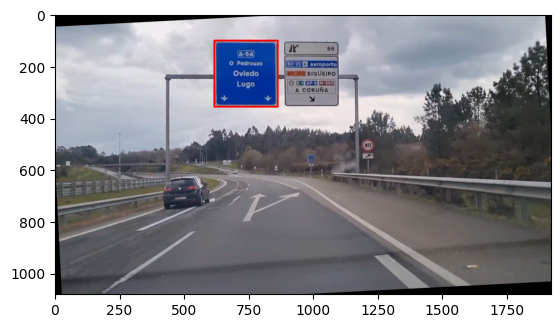

In [81]:
def drawBoxesImage(regionDetectada, imagen):
    imagenCopia = imagen.copy()
    for polygon in regionDetectada:
        x, y, w, h = polygon
        cv2.rectangle(imagenCopia, (x, y), (x + w, y + h), (0, 0, 255), 5)
    return imagenCopia

imagenFiltrada = drawBoxesImage(filteredSubpannels[101], norm_images[101])
plt.imshow(cv2.cvtColor(imagenFiltrada, cv2.COLOR_BGR2RGB))


## Evaluación de los resultados de detección

Seleccionar un subconjunto de, al menos, 20 imágenes del conjunto de imágenes de test proporcionado. Estas imágenes deben de ser lo suficientemente representativas como para contener todas las variabilidades presentes en el dataset de imágenes (p.ej., diferentes condiciones meteorológicas, diferentes tamaños y perspectivas de los sub-paneles en las escenas, etc). 

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

In [82]:
# def show_20_images(imagenes):
#     # Crear la figura y los ejes
#     fig, axs = plt.subplots(4, 5, figsize=(12, 10))

#     # Mostrar cada imagen en su respectivo subplot
#     for i, ax in enumerate(axs.flat):
#         ax.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))
#         ax.axis('off')

#     plt.show()

# imgs = []
# indices_imagenes = [0, 4, 10, 16, 20, 38, 45, 49, 54, 57, 64, 69, 70, 74, 81, 83, 93, 99, 100, 101]
# for indice in indices_imagenes:
#     imgs.append(listaImagenes[indice])

# show_20_images(imgs)

Para las 20 imágenes de test seleccionadas, pintar (por ejemplo, en color rojo), los rectángulos donde se han detectado los sub-paneles en cada una de las imágenes consideradas.

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Mostrar resultados cuantitativos de detección usando la métrica de IoU (Intersection over Union)

In [83]:
# Funciones para formatear los datos del JSON
# Función que mapea el nombre de las imágenes en sus ids
def mapImages(jsonFile):
    map = {}
    for image in jsonFile['images']:
        name = image['file_name'].split(".")[0].replace("_", ".")
        map[name] = image['id']
        #map[image['id']] = image['file_name'].split(".")[0]
    return map

# Función que mapea el id con las anotaciones realizadas a mano
def mapAnnotations(jsonFile):
    map = {}
    for anotation in jsonFile['annotations']:
        box = anotation['bbox']
        x, y, h, w = box
        if (map.get(anotation['image_id']) == None):
            list = []
            list.append((x, y, h, w))
            map[anotation['image_id']] = list
        else:
            list = map[anotation['image_id']]
            list.append(box)
            map[anotation['image_id']] = list
    return map

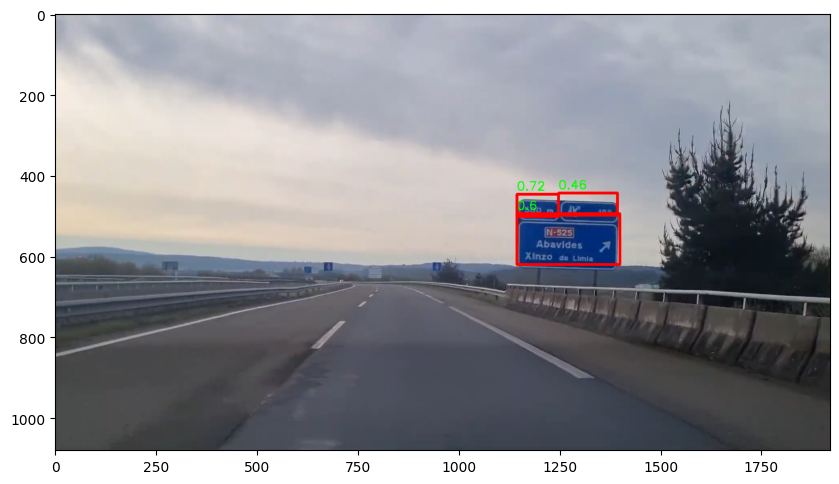

In [84]:
import json

# Obtenermos en una lista los subpaneles anotados a mano
def getPanelsGroundTruth(keys, annotations):
    filesNames = os.listdir("imagenesTest")
    annotationsGroundTruth = []
    for title in filesNames:
        key = keys.get(title)
        if (annotations.get(key) != None):
            listAnnontations = annotations.get(key)
            listAux = []
            for annotation in listAnnontations:
                x, y, w, h = annotation
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                listAux.append((x, y, w, h))
            annotationsGroundTruth.append(listAux)
        else:
            annotationsGroundTruth.append(())
    return annotationsGroundTruth

def calculeIoU(groundTruth, subpannelsDetected):
    listMeans = []
    for i in range(len(groundTruth)):
        boxesReal = groundTruth[i]
        boxesFake = subpannelsDetected[i]
        maxValue = 0
        listAux = []
        count = 0
        for boxFake in boxesReal:
            maxValue = 0
            for boxReal in boxesFake:
                valueIoU = intersectionOverUnion(boxReal, boxFake)
                maxValue = max(maxValue, valueIoU)
                count = count + 1
            if (maxValue >= 0.1): listAux.append(maxValue)
        listMeans.append(listAux)
    return listMeans

def drawBoxesImageAux(region, imagen, meanIoU):
    imagenCopia = imagen.copy()
    for i,polygon in enumerate(region):
        x, y, w, h = polygon
        iou = meanIoU[i]
        iou = round(iou, 2)
        cv2.rectangle(imagenCopia, (x, y), (x + w, y + h), (0, 0, 255), 5)
        cv2.putText(imagenCopia, str(iou), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return imagenCopia

#----------------------------------------------------------------------------------------------------------
with open('anotaciones.json', "r", encoding='utf-8') as f:
    content = json.load(f)
mapKeys = mapImages(content)
mapAnnotation = mapAnnotations(content)
pannelsGroundTruth = getPanelsGroundTruth(mapKeys, mapAnnotation)

meanIoU = calculeIoU(pannelsGroundTruth, filteredSubpannels)
imagen = drawBoxesImageAux(filteredSubpannels[5], norm_images[5], meanIoU[5])
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
